# Test SBS31 sensitibity and specificity

The exposure to SBS31 signature is further evaluated to know how sensitive and specific are the values that mSigAct are giving us.
- **Specificity** is to know if we can trust that a sample has SBS31 exposure. This is calculated by evaluating with mSigAct the presence of SBS31 in synthetic samples builded without SBS31. How many times mSigAct gives a value for SBS31 signature when this is not present in the sample? 
- **Sensitibity** is to know the range of exposure (confidence intervals). This is calculated by evaluating with mSigAct the presence of SBS31 in synthetic samples builded with increasing number of SBS31 signature. Which range of number of signatures has to contain a sample for mSigAct to give the value that corresponds to each sample?

## Specificity test

In [1]:
import os
import pandas as pd
import numpy as np

from collections import OrderedDict
import itertools
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import json

In [63]:
def minor_tick_labels():
    major_labels = ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']
    flanks = ['AA', 'AC', 'AG', 'AT', 'CA', 'CC', 'CG', 'CT',
              'GA', 'GC', 'GG', 'GT', 'TA', 'TC', 'TG', 'TT']
    minor_labels = []
    for subs in major_labels:
        for flank in flanks:
            minor_labels.append(flank[0] + subs[0] + flank[1])
    return minor_labels

def mut_key_generator():
    """

    Returns:
        Generates all possible lex sortable mutation keys
        1st component: substitution;
        2nd component: flanks

    """
    subs = ['CA', 'CG', 'CT', 'TA', 'TC', 'TG']
    for s in sorted(subs):
        for c in sorted(itertools.product(set('ACGT'), repeat=2)):
            yield tuple([s, ''.join(c)])
            
def change_dct_format(dicc):
    '''Change the format of the dictionary to be ready for the plot'''
    dicc_change = dict()
    for k, v in dicc.items():
        # split elements of channel annotation
        left = k[0]
        ref = k[1]
        alt = k[3]
        right = k[2]
        
        # write in the other format (1st substitution, 2nd context)
        new_cntxt = tuple([ref+alt, left+right])  
        dicc_change[new_cntxt] = dicc[k]
    
    dicc_sorted = OrderedDict()
    for k in mut_key_generator():
        dicc_sorted[k] = dicc_change[k]
    
    return dicc_sorted

def plot_signature(profile, title=None, ax=None):
    """
    Args:
        profile: signature-like object in lexicographic order
        title: string
        ymax: float

    Returns:
        produces the signature bar plot
    """

    total = sum(profile.values())
    if abs(total - 1) > 0.01:
        profile = defaultdict(int, {k: v / total for k, v in profile.items()})
    sns.set(font_scale=1.5)
    sns.set_style('white')
    vector = np.array([profile[k] for k in sorted(mut_key_generator())])
    
    ymax = max(vector)*1.1
    
    # set plot size
    fig.set_size_inches(15, 4)

    # bar plot
    barlist = ax.bar(range(96), vector)
    color_list = ['#72bcd4', 'k', 'r', '#7e7e7e', 'g', '#e6add8']
    for category in range(6):
        for i in range(16):
            barlist[category * 16 + i].set_color(color_list[category])
    ax.set_xlim([-0.5, 96])
    ax.set_ylim([0, ymax])

    # ax.set_ylabel('subs rel freq')
    labels = ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']
    major_ticks = np.arange(8, 8 + 16 * 5 + 1, 16)
    minor_ticks = np.arange(0.2, 96.2, 1)
    ax.tick_params(length=0, which='major', pad=20, labelsize=12)
    ax.tick_params(length=0, which='minor', pad=5, labelsize=6)
    ax.set_xticks(major_ticks, minor=False)
    ax.set_xticklabels(labels, minor=False)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_xticklabels(minor_tick_labels(), minor=True, rotation=90)
    ax.set_title(title, fontsize=24)

### Sample mutations

In [153]:
path = './msigact/'

folders = [folder for folder in os.listdir(path)if folder.startswith('A')]

SBS31_pvals = {}
SBS31_df = pd.DataFrame()
for sample in folders:
    df = pd.read_csv(path+sample+'/SBS31/results.count_matrix.tsv.mSigAct.SBS31.tsv',sep='\t')
    df = df.T
    df.reset_index(inplace=True)
    df = df.rename(columns={'index':'sample_id'})
    df['sample_id'] = [sample]
    
    df['pval'] = df['pval'].round(4)
    pvals_dict = dict(zip(df['sample_id'],df['pval']))
    SBS31_pvals.update(pvals_dict)
    sigs_cols =[col for col in df.columns if col.startswith('SBS')]
    df = df[['sample_id']+sigs_cols]
    df = df.set_index('sample_id')
    SBS31_df = pd.concat([SBS31_df,df])
SBS31_df.fillna(0,inplace=True)
sigs = ['SBS1','SBS2','SBS5','SBS13','SBS18','SBS40','SBS45','SBS31']
SBS31_df = SBS31_df[sigs]
samples_selected = ['AU2198','AU2199','AU2200','AU2202','AZ4609','AZ4610','AZ4611','AZ4612','AZ4613','AZ4614','AZ6342','AZ6371']
SBS31_df = SBS31_df[SBS31_df.index.isin(samples_selected)]
SBS31_df

,SBS1,SBS2,SBS5,SBS13,SBS18,SBS40,SBS45,SBS31
sample_id,,,,,,,,
AU2198,24.976048,22.018771,0.000000,0.0,0.000000,0.000000,131.877055,269.128127
AU2199,0.000000,53.814437,0.000000,0.0,530.139260,0.000000,0.000000,35.046304
AU2200,13.903467,12.384124,207.714362,0.0,99.875719,0.000000,78.823444,34.298884
AU2202,12.410012,0.000000,0.000000,0.0,42.862809,102.964656,0.000000,18.762523
AZ4609,0.000000,0.000000,263.598884,0.0,235.830685,422.591756,0.000000,183.978674
AZ4610,0.000000,0.000000,238.573374,0.0,0.000000,346.897460,119.276185,237.252982
AZ4611,0.000000,0.000000,198.328457,0.0,0.000000,144.365381,70.154947,100.151215
AZ4612,28.012395,0.000000,0.000000,0.0,0.000000,641.733676,0.000000,106.253928
AZ4613,0.000000,18.440010,0.000000,0.0,0.000000,262.810710,0.000000,116.749280


In [154]:
df1 = SBS31_df
sig_cols = df1.columns
df1['Total_muts'] = df1[sig_cols].sum(axis=1)
sig_cols = [sig for sig in sig_cols if sig != 'SBS31']
df1['Total_muts_no_sbs31'] = df1[sig_cols].sum(axis=1)
for sig in sig_cols:
    df1[sig] = df1.apply(lambda row: int(round(row[sig]/row['Total_muts_no_sbs31']*row['Total_muts'],0)),axis=1)
df1

,SBS1,SBS2,SBS5,SBS13,SBS18,SBS40,SBS45,SBS31,Total_muts,Total_muts_no_sbs31
sample_id,,,,,,,,,,
AU2198,63,55,0,0,0,0,330,269.128127,448.0,178.871873
AU2199,0,57,0,0,562,0,0,35.046304,619.0,583.953696
AU2200,15,13,225,0,108,0,85,34.298884,447.0,412.701116
AU2202,14,0,0,0,48,115,0,18.762523,177.0,158.237477
AZ4609,0,0,316,0,283,507,0,183.978674,1106.0,922.021326
AZ4610,0,0,319,0,0,464,159,237.252982,942.0,704.747018
AZ4611,0,0,246,0,0,179,87,100.151215,513.0,412.848785
AZ4612,32,0,0,0,0,744,0,106.253928,776.0,669.746072
AZ4613,0,26,0,0,0,372,0,116.749280,398.0,281.250720


### COSMIC signature probabilities

In [7]:
cosmic_df = pd.read_csv('../../wgs_analysis/tumor_vs_blood/signature_analysis/data/COSMIC_v3.3.1_SBS_GRCh38.txt',sep='\t')
cosmic_df['channel'] = cosmic_df['Type'].apply(lambda x: x[0]+x[2]+x[6]+x[4])
cosmic_df.set_index('channel',inplace=True)
cosmic_df.drop('Type',inplace=True,axis=1)
df = pd.read_csv('./msigact/AU2198/count_matrix.tsv',sep='\t')
order_channels = df['Unnamed: 0'].tolist()
cosmic_df = cosmic_df.reindex(order_channels)
cosmic_df[['SBS1','SBS5','SBS18']]

,SBS1,SBS5,SBS18
channel,,,
ACAA,8.760229e-04,0.012052,0.051688
ACCA,2.220120e-03,0.009337,0.015617
ACGA,1.797272e-04,0.001908,0.002505
ACTA,1.265053e-03,0.006636,0.021469
CCAA,3.050262e-04,0.007379,0.073437
...,...,...,...
GTTG,1.455855e-05,0.002380,0.002166
TTAG,2.165410e-16,0.005149,0.000686
TTCG,5.521334e-05,0.006677,0.002136


### Generate synthetic samples

In [136]:
sigs = ['SBS1', 'SBS2', 'SBS5', 'SBS13', 'SBS18', 'SBS40', 'SBS45']
samples_info = SBS31_df[sigs].to_dict(orient='index')
for d in samples_info:
    samples_info[d] = {sig:samples_info[d][sig] for sig in samples_info[d].keys() if samples_info[d][sig]!=0}
samples_info

{'AU2198': {'SBS1': 63, 'SBS2': 55, 'SBS45': 330},
 'AU2199': {'SBS2': 57, 'SBS18': 562},
 'AU2200': {'SBS1': 15, 'SBS2': 13, 'SBS5': 225, 'SBS18': 108, 'SBS45': 85},
 'AU2202': {'SBS1': 14, 'SBS18': 48, 'SBS40': 115},
 'AZ4609': {'SBS5': 316, 'SBS18': 283, 'SBS40': 507},
 'AZ4610': {'SBS5': 319, 'SBS40': 464, 'SBS45': 159},
 'AZ4611': {'SBS5': 246, 'SBS40': 179, 'SBS45': 87},
 'AZ4612': {'SBS1': 32, 'SBS40': 744},
 'AZ4613': {'SBS2': 26, 'SBS40': 372},
 'AZ4614': {'SBS18': 95, 'SBS40': 238},
 'AZ6342': {'SBS5': 105, 'SBS18': 59},
 'AZ6371': {'SBS1': 5, 'SBS40': 57}}

In [9]:
file = './synthetic_samples_specificity/samples_dict.json'
json.dump(samples_info,open(file,'w'))

In [140]:
path = './synthetic_samples_specificity/'
channels = cosmic_df.index
synth_samples_dict = {}
for sample_info in samples_info:
    print(sample_info)
    synth_samples_df = pd.DataFrame(index=channels)
    synth_samples = []
    for i in range(1,1001):
        synth_sample = {channel:0 for channel in channels}
        for sig in samples_info[sample_info].keys():
            num_muts = samples_info[sample_info][sig]
            probability_vector = cosmic_df[sig].tolist()

            counts = np.random.choice(channels,p=probability_vector,size=num_muts)
            sig_counts = {channel:np.count_nonzero(counts==channel) for channel in channels}
            synth_sample = {channel:(synth_sample[channel]+sig_counts[channel]) for channel in channels}
        synth_samples_df['SAMPLE'+str(i)] = synth_samples_df.index.map(synth_sample)
        synth_samples.append(synth_sample)
    synth_samples_dict[sample_info] = synth_samples
    display(synth_samples_df.sum())
    if not os.path.exists(path+sample_info):
        os.makedirs(path+sample_info)
    synth_samples_df.to_csv(path+sample_info+'/count_matrix.tsv',sep='\t')

AU2198


SAMPLE1       448
SAMPLE2       448
SAMPLE3       448
SAMPLE4       448
SAMPLE5       448
             ... 
SAMPLE996     448
SAMPLE997     448
SAMPLE998     448
SAMPLE999     448
SAMPLE1000    448
Length: 1000, dtype: int64

AU2199


SAMPLE1       619
SAMPLE2       619
SAMPLE3       619
SAMPLE4       619
SAMPLE5       619
             ... 
SAMPLE996     619
SAMPLE997     619
SAMPLE998     619
SAMPLE999     619
SAMPLE1000    619
Length: 1000, dtype: int64

AU2200


SAMPLE1       446
SAMPLE2       446
SAMPLE3       446
SAMPLE4       446
SAMPLE5       446
             ... 
SAMPLE996     446
SAMPLE997     446
SAMPLE998     446
SAMPLE999     446
SAMPLE1000    446
Length: 1000, dtype: int64

AU2202


SAMPLE1       177
SAMPLE2       177
SAMPLE3       177
SAMPLE4       177
SAMPLE5       177
             ... 
SAMPLE996     177
SAMPLE997     177
SAMPLE998     177
SAMPLE999     177
SAMPLE1000    177
Length: 1000, dtype: int64

AZ4609


SAMPLE1       1106
SAMPLE2       1106
SAMPLE3       1106
SAMPLE4       1106
SAMPLE5       1106
              ... 
SAMPLE996     1106
SAMPLE997     1106
SAMPLE998     1106
SAMPLE999     1106
SAMPLE1000    1106
Length: 1000, dtype: int64

AZ4610


SAMPLE1       942
SAMPLE2       942
SAMPLE3       942
SAMPLE4       942
SAMPLE5       942
             ... 
SAMPLE996     942
SAMPLE997     942
SAMPLE998     942
SAMPLE999     942
SAMPLE1000    942
Length: 1000, dtype: int64

AZ4611


SAMPLE1       512
SAMPLE2       512
SAMPLE3       512
SAMPLE4       512
SAMPLE5       512
             ... 
SAMPLE996     512
SAMPLE997     512
SAMPLE998     512
SAMPLE999     512
SAMPLE1000    512
Length: 1000, dtype: int64

AZ4612


SAMPLE1       776
SAMPLE2       776
SAMPLE3       776
SAMPLE4       776
SAMPLE5       776
             ... 
SAMPLE996     776
SAMPLE997     776
SAMPLE998     776
SAMPLE999     776
SAMPLE1000    776
Length: 1000, dtype: int64

AZ4613


SAMPLE1       398
SAMPLE2       398
SAMPLE3       398
SAMPLE4       398
SAMPLE5       398
             ... 
SAMPLE996     398
SAMPLE997     398
SAMPLE998     398
SAMPLE999     398
SAMPLE1000    398
Length: 1000, dtype: int64

AZ4614


SAMPLE1       333
SAMPLE2       333
SAMPLE3       333
SAMPLE4       333
SAMPLE5       333
             ... 
SAMPLE996     333
SAMPLE997     333
SAMPLE998     333
SAMPLE999     333
SAMPLE1000    333
Length: 1000, dtype: int64

AZ6342


SAMPLE1       164
SAMPLE2       164
SAMPLE3       164
SAMPLE4       164
SAMPLE5       164
             ... 
SAMPLE996     164
SAMPLE997     164
SAMPLE998     164
SAMPLE999     164
SAMPLE1000    164
Length: 1000, dtype: int64

AZ6371


SAMPLE1       62
SAMPLE2       62
SAMPLE3       62
SAMPLE4       62
SAMPLE5       62
              ..
SAMPLE996     62
SAMPLE997     62
SAMPLE998     62
SAMPLE999     62
SAMPLE1000    62
Length: 1000, dtype: int64

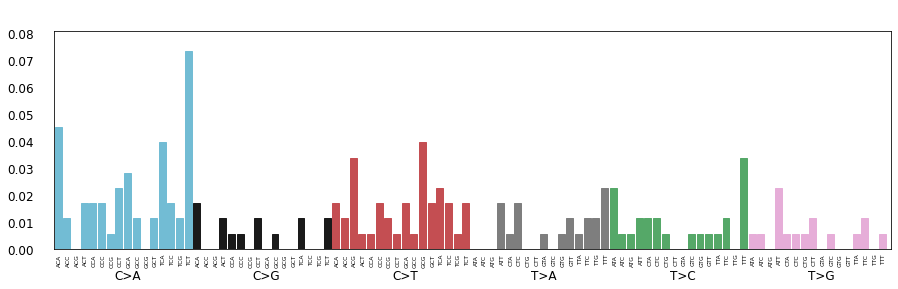

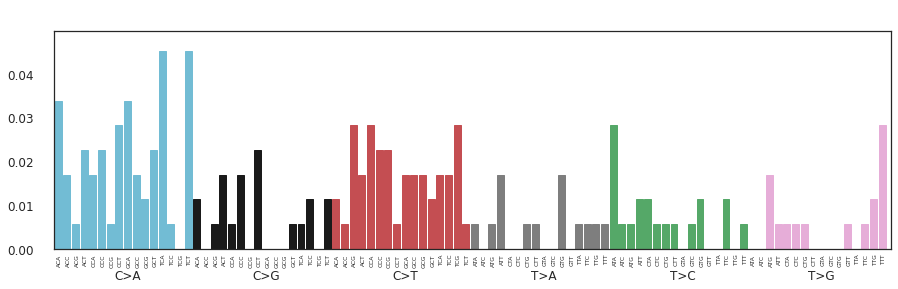

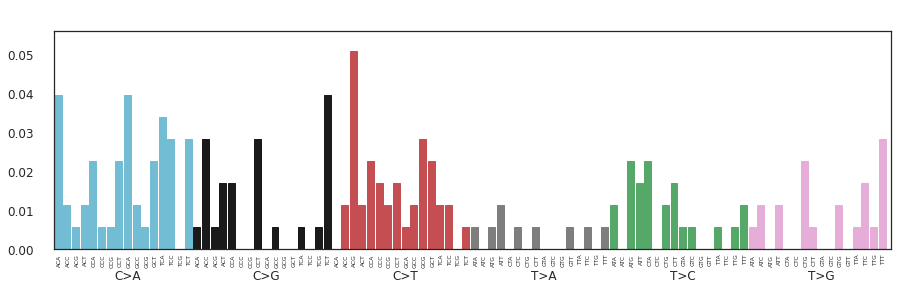

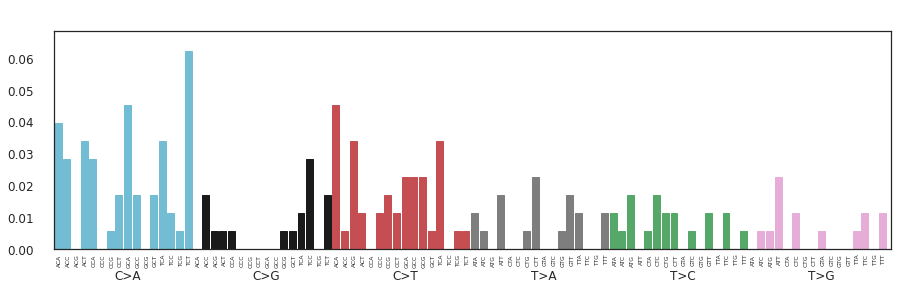

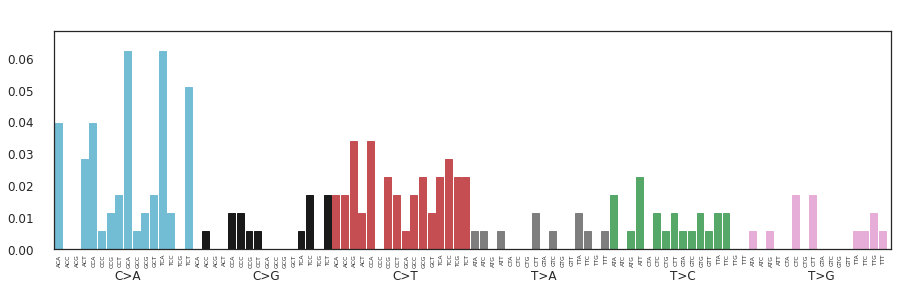

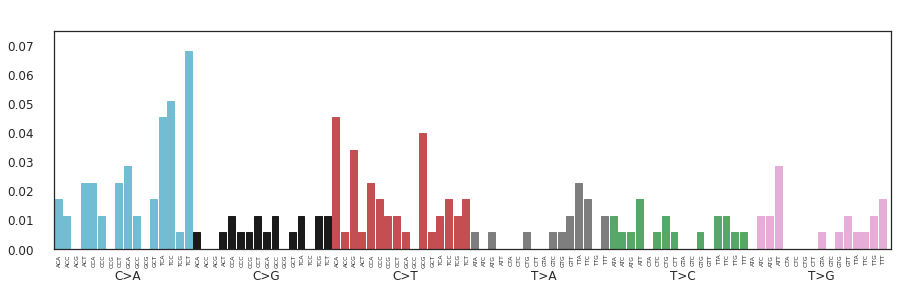

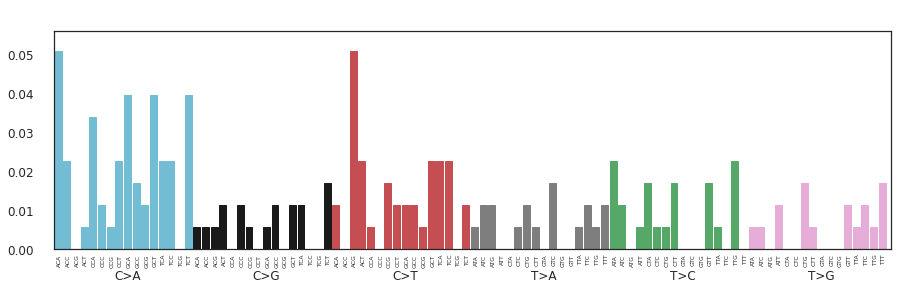

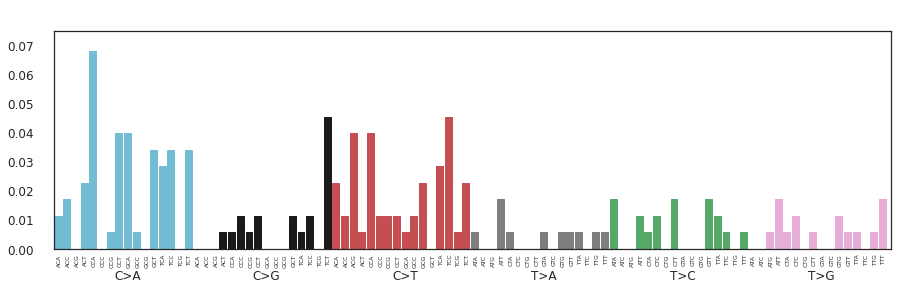

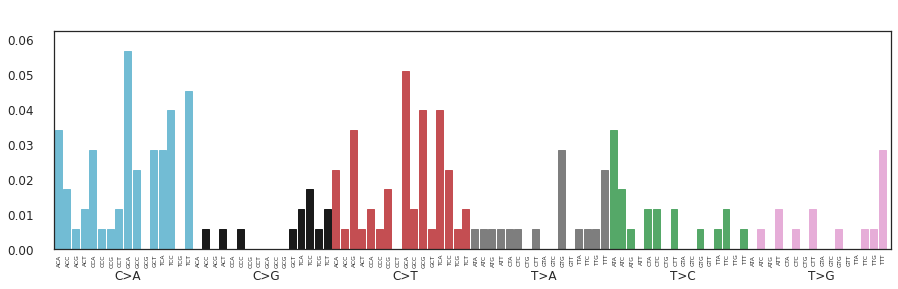

In [64]:
#check profiles to see that the synthetic samples are similar
samples_df = pd.read_csv('./synthetic_samples_specificity/AU2202/count_matrix.tsv',sep='\t')

for colname in ['SAMPLE'+str(n) for n in range(1,10)]:
    dictionary = dict(zip(samples_df['channel'],samples_df[colname]))
    dict_counts = change_dct_format(dictionary)
    fig, ax = plt.subplots()
    plot_signature(dict_counts, title=' ' ,ax=ax)
    plt.show()

### Run signature tables and mSigAct with qmap

Run the qmaps prepared in this notebook (synthetic specificity): ```qmap_msigact.ipynb```

### Check results msigact

In [151]:
samples_name_dict = {'AU2198':'Case 2, Blood',
                    'AU2199':'Case 2, EPN',
                    'AU2200':'Case 2, DMG',
                    'AU2202':'Case 3, MRT',
                    'AZ4609':'Case 3, Kidney',
                    'AZ4610':'Case 3, Liver',
                    'AZ4611':'Case 3, Pancreas',
                    'AZ4612':'Case 3, Lung',
                    'AZ4613':'Case 3, Spleen',
                    'AZ4614':'Case 3, Bone Marrow',
                    'AZ6342':'Unrelated non-treated donor 1, Blood',
                    'AZ6371':'Unrelated non-treated donor 2, Blood'}

AU2198
AU2199
AU2200
AU2202
AZ4609
AZ4610
AZ4611
AZ4612
AZ4613
AZ4614
AZ6342
AZ6371


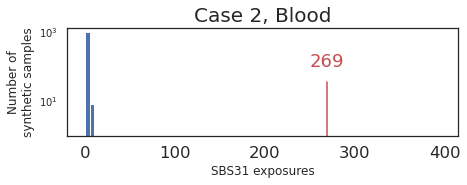

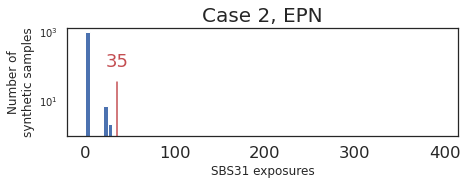

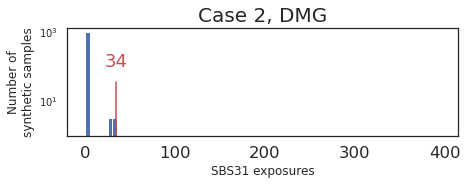

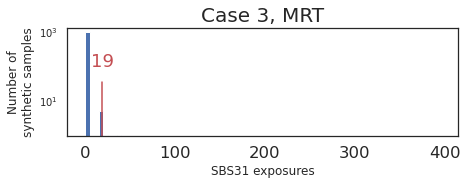

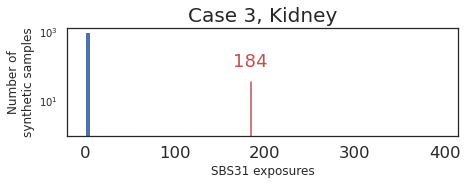

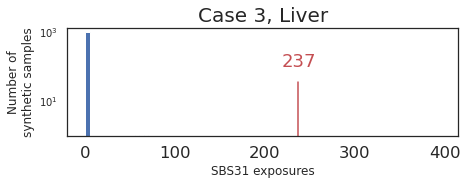

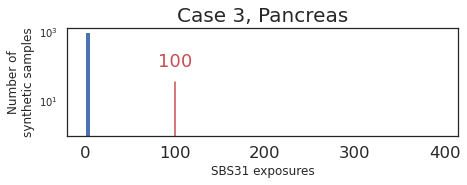

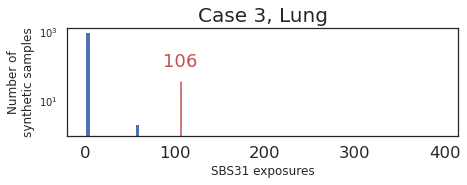

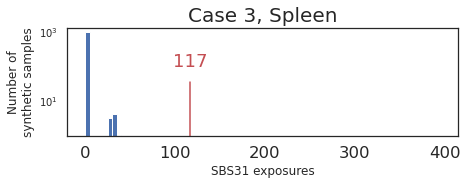

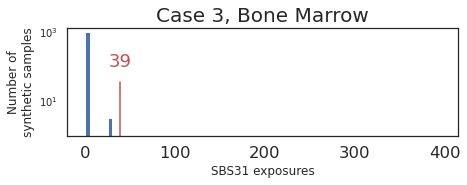

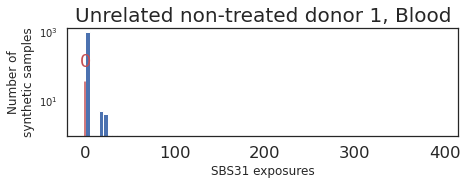

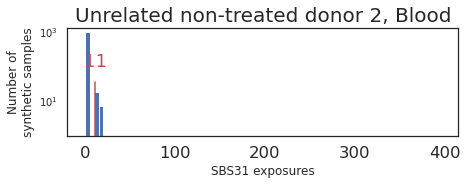

In [155]:
for sample in samples_name_dict.keys():
    msigact_value = SBS31_df['SBS31'][SBS31_df.index==sample][0]
    df = pd.read_csv('./synthetic_samples_specificity/'+sample+'/SBS31/results.count_matrix.tsv.mSigAct.SBS31.tsv',sep='\t')
    print(sample)
    df['SAMPLES'] = df.index
    plt.figure(figsize=(7,2))
    plt.hist(df['SBS31'],bins=range(0,400,5))
    plt.axvline(msigact_value,color='r',ymax=0.5)
    plt.yticks([0.1,0,10,100,1000],size=10)
    plt.yscale('log')
    plt.text(x=msigact_value,y=100,s=int(round(msigact_value,0)),ha='center',color='r')
    plt.title(samples_name_dict[sample],size=20)
    plt.xlabel('SBS31 exposures',size=12)
    plt.ylabel('Number of\nsynthetic samples',size=12)
    plt.ylim(0.9,1300)
    plt.savefig('./figures_paper/specificity_'+sample+'.png',dpi=300, format='png',transparent=True,bbox_inches='tight')


-------------------------------

## Sensitivity test synthetic samples with SBS31 injections, to get the CI

In [142]:
path = './msigact/'

folders_dict = {path+folder+'/SBS31/results.count_matrix.tsv.mSigAct.SBS31.tsv':folder for folder in os.listdir(path)if folder.startswith('A')}

case1_sample_t2 = '../../wgs_analysis/tumor_vs_blood/signature_analysis/msigact/clonals/output_sbs31/results.clonals.matrix.tsv.mSigAct.SBS31.tsv'

folders_dict[case1_sample_t2] = 'AQ5187_vs_AQ5175'

SBS31_pvals = {}
SBS31_df = pd.DataFrame()
for sample in folders_dict.keys():
    df = pd.read_csv(sample,sep='\t')
    df = df.T
    df.reset_index(inplace=True)
    df = df.rename(columns={'index':'sample_id'})
    if folders_dict[sample] == 'AQ5187_vs_AQ5175':
        df = df.set_index('sample_id',drop=True)
        df = df.T
        df = df.reset_index()
        df = df.rename(columns={'index':'sample_id'})
        df = df[df['sample_id']=='AQ5187_vs_AQ5175']
    else:
        df['sample_id'] = [folders_dict[sample]]
    
    df['pval'] = df['pval'].round(4)
    pvals_dict = dict(zip(df['sample_id'],df['pval']))
    SBS31_pvals.update(pvals_dict)
    sigs_cols =[col for col in df.columns if col.startswith('SBS')]
    df = df[['sample_id']+sigs_cols]
    df = df.set_index('sample_id')
    SBS31_df = pd.concat([SBS31_df,df])
SBS31_df.fillna(0,inplace=True)
sigs = ['SBS1','SBS2','SBS5','SBS13','SBS18','SBS40','SBS45','SBS31']
SBS31_df = SBS31_df[sigs]
samples_selected = ['AQ5187_vs_AQ5175','AU2198','AZ4609','AZ4610','AZ4611','AZ4612','AZ4613','AZ4614']
SBS31_df = SBS31_df[SBS31_df.index.isin(samples_selected)]
SBS31_df

,SBS1,SBS2,SBS5,SBS13,SBS18,SBS40,SBS45,SBS31
sample_id,,,,,,,,
AU2198,24.976048,22.018771,0.000000,0.0,0.000000,0.000000,131.877055,269.128127
AZ4609,0.000000,0.000000,263.598884,0.0,235.830685,422.591756,0.000000,183.978674
AZ4610,0.000000,0.000000,238.573374,0.0,0.000000,346.897460,119.276185,237.252982
AZ4611,0.000000,0.000000,198.328457,0.0,0.000000,144.365381,70.154947,100.151215
AZ4612,28.012395,0.000000,0.000000,0.0,0.000000,641.733676,0.000000,106.253928
AZ4613,0.000000,18.440010,0.000000,0.0,0.000000,262.810710,0.000000,116.749280
AZ4614,0.000000,0.000000,0.000000,0.0,83.727583,210.395296,0.000000,38.877122
AQ5187_vs_AQ5175,153.632827,0.000000,982.093386,0.0,163.313380,0.000000,0.000000,931.960407


In [14]:
from tqdm.notebook import tqdm
pd.options.mode.chained_assignment = None

In [143]:
all_samples_dict = {}
for sample in SBS31_df.index:
    if sample != 'AQ5187_vs_AQ5175':
        samples_dict = {}
        for muts in tqdm(range(0,500,5)):
            df1 = SBS31_df[SBS31_df.index==sample]
            sig_cols = df1.columns
            df1['Total_muts'] = df1[sig_cols].sum(axis=1)
            if muts > df1['Total_muts'][0]:
                break
            else:
                df1['SBS31'] = muts
                sig_cols = [sig for sig in sig_cols if sig != 'SBS31']
                df1['Total_muts_no_sbs31'] = df1[sig_cols].sum(axis=1)
                df1['Total_muts_no_sbs31'] = df1['Total_muts_no_sbs31']

                for sig in sig_cols:
                    df1[sig] = df1.apply(lambda row: int(round(row[sig]/row['Total_muts_no_sbs31']*(row['Total_muts']-muts),0)),axis=1)
                sigs = ['SBS1', 'SBS2', 'SBS5', 'SBS13', 'SBS18', 'SBS40', 'SBS45', 'SBS31']
                sample_dict = df1[sigs].to_dict(orient='list')
                sample_dict = {s:sample_dict[s][0] for s in sample_dict.keys() if sample_dict[s][0]!=0}
                samples_dict['SBS31_'+(str(muts))] = sample_dict
        all_samples_dict[sample] = samples_dict
display(all_samples_dict)



{'AU2198': {'SBS31_0': {'SBS1': 63, 'SBS2': 55, 'SBS45': 330},
  'SBS31_5': {'SBS1': 62, 'SBS2': 55, 'SBS45': 327, 'SBS31': 5},
  'SBS31_10': {'SBS1': 61, 'SBS2': 54, 'SBS45': 323, 'SBS31': 10},
  'SBS31_15': {'SBS1': 60, 'SBS2': 53, 'SBS45': 319, 'SBS31': 15},
  'SBS31_20': {'SBS1': 60, 'SBS2': 53, 'SBS45': 316, 'SBS31': 20},
  'SBS31_25': {'SBS1': 59, 'SBS2': 52, 'SBS45': 312, 'SBS31': 25},
  'SBS31_30': {'SBS1': 58, 'SBS2': 51, 'SBS45': 308, 'SBS31': 30},
  'SBS31_35': {'SBS1': 58, 'SBS2': 51, 'SBS45': 304, 'SBS31': 35},
  'SBS31_40': {'SBS1': 57, 'SBS2': 50, 'SBS45': 301, 'SBS31': 40},
  'SBS31_45': {'SBS1': 56, 'SBS2': 50, 'SBS45': 297, 'SBS31': 45},
  'SBS31_50': {'SBS1': 56, 'SBS2': 49, 'SBS45': 293, 'SBS31': 50},
  'SBS31_55': {'SBS1': 55, 'SBS2': 48, 'SBS45': 290, 'SBS31': 55},
  'SBS31_60': {'SBS1': 54, 'SBS2': 48, 'SBS45': 286, 'SBS31': 60},
  'SBS31_65': {'SBS1': 53, 'SBS2': 47, 'SBS45': 282, 'SBS31': 65},
  'SBS31_70': {'SBS1': 53, 'SBS2': 47, 'SBS45': 279, 'SBS31': 70},
 

In [146]:
# samples from case1 (WGS analysis) need a bigger range for the injections (up to 1600)
pt1_samples_dict = {}
sample = 'AQ5187_vs_AQ5175'
samples_dict = {}
for muts in tqdm(range(0,1600,5)):
    df1 = SBS31_df[SBS31_df.index==sample]
    sig_cols = df1.columns
    df1['Total_muts'] = df1[sig_cols].sum(axis=1)
    if muts > df1['Total_muts'][0]:
        break
    else:
        df1['SBS31'] = muts
        sig_cols = [sig for sig in sig_cols if sig != 'SBS31']
        df1['Total_muts_no_sbs31'] = df1[sig_cols].sum(axis=1)
        df1['Total_muts_no_sbs31'] = df1['Total_muts_no_sbs31']

        for sig in sig_cols:
            df1[sig] = df1.apply(lambda row: int(round(row[sig]/row['Total_muts_no_sbs31']*(row['Total_muts']-muts),0)),axis=1)
        sigs = ['SBS1', 'SBS2', 'SBS5', 'SBS13', 'SBS18', 'SBS40', 'SBS45', 'SBS31']
        sample_dict = df1[sigs].to_dict(orient='list')
        sample_dict = {s:sample_dict[s][0] for s in sample_dict.keys() if sample_dict[s][0]!=0}
        samples_dict['SBS31_'+(str(muts))] = sample_dict
pt1_samples_dict[sample] = samples_dict
display(pt1_samples_dict)



{'AQ5187_vs_AQ5175': {'SBS31_0': {'SBS1': 264, 'SBS5': 1687, 'SBS18': 280},
  'SBS31_5': {'SBS1': 263, 'SBS5': 1683, 'SBS18': 280, 'SBS31': 5},
  'SBS31_10': {'SBS1': 263, 'SBS5': 1679, 'SBS18': 279, 'SBS31': 10},
  'SBS31_15': {'SBS1': 262, 'SBS5': 1675, 'SBS18': 279, 'SBS31': 15},
  'SBS31_20': {'SBS1': 261, 'SBS5': 1672, 'SBS18': 278, 'SBS31': 20},
  'SBS31_25': {'SBS1': 261, 'SBS5': 1668, 'SBS18': 277, 'SBS31': 25},
  'SBS31_30': {'SBS1': 260, 'SBS5': 1664, 'SBS18': 277, 'SBS31': 30},
  'SBS31_35': {'SBS1': 260, 'SBS5': 1660, 'SBS18': 276, 'SBS31': 35},
  'SBS31_40': {'SBS1': 259, 'SBS5': 1656, 'SBS18': 275, 'SBS31': 40},
  'SBS31_45': {'SBS1': 259, 'SBS5': 1653, 'SBS18': 275, 'SBS31': 45},
  'SBS31_50': {'SBS1': 258, 'SBS5': 1649, 'SBS18': 274, 'SBS31': 50},
  'SBS31_55': {'SBS1': 257, 'SBS5': 1645, 'SBS18': 274, 'SBS31': 55},
  'SBS31_60': {'SBS1': 257, 'SBS5': 1641, 'SBS18': 273, 'SBS31': 60},
  'SBS31_65': {'SBS1': 256, 'SBS5': 1638, 'SBS18': 272, 'SBS31': 65},
  'SBS31_70': {'

In [147]:
file = './synthetic_samples_sensitibity/all_samples_dict.json'
json.dump(all_samples_dict,open(file,'w'))
file = './synthetic_samples_sensitibity/case1_samples_dict.json'
json.dump(pt1_samples_dict,open(file,'w'))

### COSMIC signature probabilities

In [17]:
cosmic_df = pd.read_csv('../../wgs_analysis/tumor_vs_blood/signature_analysis/data/COSMIC_v3.3.1_SBS_GRCh38.txt',sep='\t')
cosmic_df['channel'] = cosmic_df['Type'].apply(lambda x: x[0]+x[2]+x[6]+x[4])
cosmic_df.set_index('channel',inplace=True)
cosmic_df.drop('Type',inplace=True,axis=1)
df = pd.read_csv('./msigact/AU2198/count_matrix.tsv',sep='\t')
order_channels = df['Unnamed: 0'].tolist()
cosmic_df = cosmic_df.reindex(order_channels)
cosmic_df[sigs]

,SBS1,SBS2,SBS5,SBS13,SBS18,SBS40,SBS45,SBS31
channel,,,,,,,,
ACAA,8.760229e-04,5.790059e-07,0.012052,1.816879e-03,0.051688,0.028323,0.009178,0.009609
ACCA,2.220120e-03,1.455045e-04,0.009337,7.088425e-04,0.015617,0.013254,0.002828,0.018351
ACGA,1.797272e-04,5.361861e-05,0.001908,2.706559e-04,0.002505,0.003012,0.001717,0.001717
ACTA,1.265053e-03,9.759122e-05,0.006636,3.472568e-04,0.021469,0.014858,0.009708,0.006323
CCAA,3.050262e-04,2.053143e-04,0.007379,1.381922e-03,0.073437,0.020657,0.237080,0.010657
...,...,...,...,...,...,...,...,...
GTTG,1.455855e-05,2.245140e-16,0.002380,2.909618e-06,0.002166,0.005551,0.000504,0.002854
TTAG,2.165410e-16,1.637288e-05,0.005149,1.803956e-04,0.000686,0.008345,0.000282,0.002226
TTCG,5.521334e-05,7.122596e-05,0.006677,2.246044e-16,0.002136,0.011604,0.000138,0.002430


### Generate synthetic samples

In [19]:
#all samples (except case1)
path = './synthetic_samples_sensitibity/'
channels = cosmic_df.index
synth_samples_dict = {}
for sample_id in tqdm(all_samples_dict.keys()):
    print(sample_id)
    synth_samples_df = pd.DataFrame(index=channels)
    synth_samples = []
    samples_dict = all_samples_dict[sample_id]
    for muts in tqdm(samples_dict.keys()):
        for i in range(1,101):
            synth_sample = {channel:0 for channel in channels}
            muts_dict = samples_dict[muts]
            for sig in muts_dict.keys():
                num_muts = muts_dict[sig]
                probability_vector = cosmic_df[sig].tolist()

                counts = np.random.choice(channels,p=probability_vector,size=num_muts)
                sig_counts = {channel:np.count_nonzero(counts==channel) for channel in channels}
                synth_sample = {channel:(synth_sample[channel]+sig_counts[channel]) for channel in channels}
            synth_samples_df['SAMPLE_'+str(muts)+'_'+str(i)] = synth_samples_df.index.map(synth_sample)
            synth_samples.append(synth_sample)
    synth_samples_dict[sample_id] = synth_samples
    print('Total number of muts per sample:')
    display(synth_samples_df.sum())
    if not os.path.exists(path+sample_id):
        os.makedirs(path+sample_id)
    synth_samples_df.to_csv(path+sample_id+'/count_matrix.tsv',sep='\t')

AU2198



Total number of muts per sample:


SAMPLE_SBS31_0_1        448
SAMPLE_SBS31_0_2        448
SAMPLE_SBS31_0_3        448
SAMPLE_SBS31_0_4        448
SAMPLE_SBS31_0_5        448
                       ... 
SAMPLE_SBS31_445_96     447
SAMPLE_SBS31_445_97     447
SAMPLE_SBS31_445_98     447
SAMPLE_SBS31_445_99     447
SAMPLE_SBS31_445_100    447
Length: 9000, dtype: int64

AU2199



Total number of muts per sample:


SAMPLE_SBS31_0_1        619
SAMPLE_SBS31_0_2        619
SAMPLE_SBS31_0_3        619
SAMPLE_SBS31_0_4        619
SAMPLE_SBS31_0_5        619
                       ... 
SAMPLE_SBS31_495_96     619
SAMPLE_SBS31_495_97     619
SAMPLE_SBS31_495_98     619
SAMPLE_SBS31_495_99     619
SAMPLE_SBS31_495_100    619
Length: 10000, dtype: int64

AU2200



Total number of muts per sample:


SAMPLE_SBS31_0_1        446
SAMPLE_SBS31_0_2        446
SAMPLE_SBS31_0_3        446
SAMPLE_SBS31_0_4        446
SAMPLE_SBS31_0_5        446
                       ... 
SAMPLE_SBS31_445_96     446
SAMPLE_SBS31_445_97     446
SAMPLE_SBS31_445_98     446
SAMPLE_SBS31_445_99     446
SAMPLE_SBS31_445_100    446
Length: 9000, dtype: int64

AU2202



Total number of muts per sample:


SAMPLE_SBS31_0_1        177
SAMPLE_SBS31_0_2        177
SAMPLE_SBS31_0_3        177
SAMPLE_SBS31_0_4        177
SAMPLE_SBS31_0_5        177
                       ... 
SAMPLE_SBS31_175_96     177
SAMPLE_SBS31_175_97     177
SAMPLE_SBS31_175_98     177
SAMPLE_SBS31_175_99     177
SAMPLE_SBS31_175_100    177
Length: 3600, dtype: int64

AZ4609



Total number of muts per sample:


SAMPLE_SBS31_0_1        1106
SAMPLE_SBS31_0_2        1106
SAMPLE_SBS31_0_3        1106
SAMPLE_SBS31_0_4        1106
SAMPLE_SBS31_0_5        1106
                        ... 
SAMPLE_SBS31_495_96     1106
SAMPLE_SBS31_495_97     1106
SAMPLE_SBS31_495_98     1106
SAMPLE_SBS31_495_99     1106
SAMPLE_SBS31_495_100    1106
Length: 10000, dtype: int64

AZ4610



Total number of muts per sample:


SAMPLE_SBS31_0_1        942
SAMPLE_SBS31_0_2        942
SAMPLE_SBS31_0_3        942
SAMPLE_SBS31_0_4        942
SAMPLE_SBS31_0_5        942
                       ... 
SAMPLE_SBS31_495_96     942
SAMPLE_SBS31_495_97     942
SAMPLE_SBS31_495_98     942
SAMPLE_SBS31_495_99     942
SAMPLE_SBS31_495_100    942
Length: 10000, dtype: int64

AZ4611



Total number of muts per sample:


SAMPLE_SBS31_0_1        512
SAMPLE_SBS31_0_2        512
SAMPLE_SBS31_0_3        512
SAMPLE_SBS31_0_4        512
SAMPLE_SBS31_0_5        512
                       ... 
SAMPLE_SBS31_495_96     513
SAMPLE_SBS31_495_97     513
SAMPLE_SBS31_495_98     513
SAMPLE_SBS31_495_99     513
SAMPLE_SBS31_495_100    513
Length: 10000, dtype: int64

AZ4612



Total number of muts per sample:


SAMPLE_SBS31_0_1        776
SAMPLE_SBS31_0_2        776
SAMPLE_SBS31_0_3        776
SAMPLE_SBS31_0_4        776
SAMPLE_SBS31_0_5        776
                       ... 
SAMPLE_SBS31_495_96     776
SAMPLE_SBS31_495_97     776
SAMPLE_SBS31_495_98     776
SAMPLE_SBS31_495_99     776
SAMPLE_SBS31_495_100    776
Length: 10000, dtype: int64

AZ4613



Total number of muts per sample:


SAMPLE_SBS31_0_1        398
SAMPLE_SBS31_0_2        398
SAMPLE_SBS31_0_3        398
SAMPLE_SBS31_0_4        398
SAMPLE_SBS31_0_5        398
                       ... 
SAMPLE_SBS31_395_96     398
SAMPLE_SBS31_395_97     398
SAMPLE_SBS31_395_98     398
SAMPLE_SBS31_395_99     398
SAMPLE_SBS31_395_100    398
Length: 8000, dtype: int64

AZ4614



Total number of muts per sample:


SAMPLE_SBS31_0_1        333
SAMPLE_SBS31_0_2        333
SAMPLE_SBS31_0_3        333
SAMPLE_SBS31_0_4        333
SAMPLE_SBS31_0_5        333
                       ... 
SAMPLE_SBS31_330_96     333
SAMPLE_SBS31_330_97     333
SAMPLE_SBS31_330_98     333
SAMPLE_SBS31_330_99     333
SAMPLE_SBS31_330_100    333
Length: 6700, dtype: int64

AZ6342



Total number of muts per sample:


SAMPLE_SBS31_0_1        164
SAMPLE_SBS31_0_2        164
SAMPLE_SBS31_0_3        164
SAMPLE_SBS31_0_4        164
SAMPLE_SBS31_0_5        164
                       ... 
SAMPLE_SBS31_160_96     164
SAMPLE_SBS31_160_97     164
SAMPLE_SBS31_160_98     164
SAMPLE_SBS31_160_99     164
SAMPLE_SBS31_160_100    164
Length: 3300, dtype: int64

AZ6371



Total number of muts per sample:


SAMPLE_SBS31_0_1       62
SAMPLE_SBS31_0_2       62
SAMPLE_SBS31_0_3       62
SAMPLE_SBS31_0_4       62
SAMPLE_SBS31_0_5       62
                       ..
SAMPLE_SBS31_60_96     62
SAMPLE_SBS31_60_97     62
SAMPLE_SBS31_60_98     62
SAMPLE_SBS31_60_99     62
SAMPLE_SBS31_60_100    62
Length: 1300, dtype: int64

AQ5187_vs_AQ5175



Total number of muts per sample:


SAMPLE_SBS31_0_1        2231
SAMPLE_SBS31_0_2        2231
SAMPLE_SBS31_0_3        2231
SAMPLE_SBS31_0_4        2231
SAMPLE_SBS31_0_5        2231
                        ... 
SAMPLE_SBS31_495_96     2230
SAMPLE_SBS31_495_97     2230
SAMPLE_SBS31_495_98     2230
SAMPLE_SBS31_495_99     2230
SAMPLE_SBS31_495_100    2230
Length: 10000, dtype: int64

AQ5181_vs_AQ5175



Total number of muts per sample:


SAMPLE_SBS31_0_1        1259
SAMPLE_SBS31_0_2        1259
SAMPLE_SBS31_0_3        1259
SAMPLE_SBS31_0_4        1259
SAMPLE_SBS31_0_5        1259
                        ... 
SAMPLE_SBS31_495_96     1259
SAMPLE_SBS31_495_97     1259
SAMPLE_SBS31_495_98     1259
SAMPLE_SBS31_495_99     1259
SAMPLE_SBS31_495_100    1259
Length: 10000, dtype: int64

In [130]:
#case1 samples
path = './synthetic_samples_sensitibity/'
channels = cosmic_df.index
synth_samples_dict = {}
for sample_id in tqdm(pt1_samples_dict.keys()):
    print(sample_id)
    synth_samples_df = pd.DataFrame(index=channels)
    synth_samples = []
    samples_dict = pt1_samples_dict[sample_id]
    for muts in tqdm(samples_dict.keys()):
        for i in range(1,101):
            synth_sample = {channel:0 for channel in channels}
            muts_dict = samples_dict[muts]
            for sig in muts_dict.keys():
                num_muts = muts_dict[sig]
                probability_vector = cosmic_df[sig].tolist()

                counts = np.random.choice(channels,p=probability_vector,size=num_muts)
                sig_counts = {channel:np.count_nonzero(counts==channel) for channel in channels}
                synth_sample = {channel:(synth_sample[channel]+sig_counts[channel]) for channel in channels}
            synth_samples_df['SAMPLE_'+str(muts)+'_'+str(i)] = synth_samples_df.index.map(synth_sample)
            synth_samples.append(synth_sample)
    synth_samples_dict[sample_id] = synth_samples
    print('Total number of muts per sample:')
    display(synth_samples_df.sum())
    if not os.path.exists(path+sample_id):
        os.makedirs(path+sample_id)
    synth_samples_df.to_csv(path+sample_id+'/count_matrix.tsv',sep='\t')

AQ5181_vs_AQ5175



Total number of muts per sample:


SAMPLE_SBS31_0_1         1259
SAMPLE_SBS31_0_2         1259
SAMPLE_SBS31_0_3         1259
SAMPLE_SBS31_0_4         1259
SAMPLE_SBS31_0_5         1259
                         ... 
SAMPLE_SBS31_1255_96     1260
SAMPLE_SBS31_1255_97     1260
SAMPLE_SBS31_1255_98     1260
SAMPLE_SBS31_1255_99     1260
SAMPLE_SBS31_1255_100    1260
Length: 25200, dtype: int64

AQ5187_vs_AQ5175



Total number of muts per sample:


SAMPLE_SBS31_0_1         2231
SAMPLE_SBS31_0_2         2231
SAMPLE_SBS31_0_3         2231
SAMPLE_SBS31_0_4         2231
SAMPLE_SBS31_0_5         2231
                         ... 
SAMPLE_SBS31_1595_96     2231
SAMPLE_SBS31_1595_97     2231
SAMPLE_SBS31_1595_98     2231
SAMPLE_SBS31_1595_99     2231
SAMPLE_SBS31_1595_100    2231
Length: 32000, dtype: int64

### Run signature tables and mSigAct with qmap

Run the qmaps prepared in this notebook (synthetic sensitibity): ```qmap_msigact.ipynb```

### Check results msigact

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [132]:
samples_name_dict = {'AU2198':'Case 2, Blood',
                    'AZ4609':'Case 3, Kidney',
                    'AZ4610':'Case 3, Liver',
                    'AZ4611':'Case 3, Pancreas',
                    'AZ4612':'Case 3, Lung',
                    'AZ4613':'Case 3, Spleen',
                    'AZ4614':'Case 3, Bone Marrow',
                    'AQ5187_vs_AQ5175':'Case 1, tAML'}

#### Check aging signatures

In [34]:
aging_sigs = ['SBS1','SBS5','SBS40']
SBS31_df[aging_sigs][SBS31_df.index==sample].sum(axis=1)[0]

1135.726212993587

In [148]:
SBS31_df

,SBS1,SBS2,SBS5,SBS13,SBS18,SBS40,SBS45,SBS31
sample_id,,,,,,,,
AU2198,24.976048,22.018771,0.000000,0.0,0.000000,0.000000,131.877055,269.128127
AZ4609,0.000000,0.000000,263.598884,0.0,235.830685,422.591756,0.000000,183.978674
AZ4610,0.000000,0.000000,238.573374,0.0,0.000000,346.897460,119.276185,237.252982
AZ4611,0.000000,0.000000,198.328457,0.0,0.000000,144.365381,70.154947,100.151215
AZ4612,28.012395,0.000000,0.000000,0.0,0.000000,641.733676,0.000000,106.253928
AZ4613,0.000000,18.440010,0.000000,0.0,0.000000,262.810710,0.000000,116.749280
AZ4614,0.000000,0.000000,0.000000,0.0,83.727583,210.395296,0.000000,38.877122
AQ5187_vs_AQ5175,153.632827,0.000000,982.093386,0.0,163.313380,0.000000,0.000000,931.960407


In [48]:
def capped_kde_pdf(data, x):
    
    min_ = min(data)
    max_ = max(data)
    
    kde = stats.gaussian_kde(data, bw_method=2)
    
    if (x < min_) or (x > max_):
        return 0
    else:
        return kde.pdf(x)[0]

    
def discrete_confidence_interval(observed, lookup_df, confidence_level):
    
    true_injected = list(map(int, lookup_df.columns))
    xs = [observed] * lookup_df.shape[0]
    p = np.array(list(map(lambda x: capped_kde_pdf(*x), zip(lookup_df.values.T, xs))))
    p = p / sum(p)

    sortindex = np.argsort(p)[::-1]
    
    acc = 0
    ci = []
    for i, a in enumerate(p[sortindex]):
        acc += a
        ci += [true_injected[sortindex[i]]]
        if acc > confidence_level:
            break
    
    ci_low = min(ci)
    ci_high = max(ci)
    return ci_low, ci_high

In [114]:

def plot_injections_aging(all_samples_dict,sample,text_loc_y1,text_loc_y2,interval=100,x_min=0,x_max=None,y_max=None):
    aging_sigs = ['SBS1','SBS5','SBS40']
    msigact_value_aging = SBS31_df[aging_sigs][SBS31_df.index==sample].sum(axis=1)[0]
    msigact_value_sbs31 = SBS31_df['SBS31'][SBS31_df.index==sample][0]
    df = pd.read_csv('./synthetic_samples_sensitibity/'+sample+'/SBS31/results.count_matrix.tsv.mSigAct.SBS31.tsv',sep='\t')
    df = df.reset_index()
    df['SBS31_injected'] = df['index'].apply(lambda x: 'SBS31_' + x.split('_')[2])
    for aging_sig in aging_sigs:
        df[aging_sig+'_injected'] = df['SBS31_injected'].apply(lambda x: all_samples_dict[sample][x][aging_sig] if aging_sig in all_samples_dict[sample][x].keys() else 0)
    aging_sigs_cols = [sig + '_injected' for sig in aging_sigs if sig in all_samples_dict[sample]['SBS31_0'].keys() ]
    df['aging_sigs_injected'] = df[aging_sigs_cols].sum(axis=1)
    aging_sigs_cols = [sig for sig in aging_sigs if sig in all_samples_dict[sample]['SBS31_0'].keys() ]
    df['aging_sigs_extracted'] = df[aging_sigs_cols].sum(axis=1)
    
    df['SBS31_injected_int'] = df['SBS31_injected'].str.split('_',expand=True)[1]
    
    injections = df['SBS31_injected_int'].unique()
    injections = [int(inj) for inj in injections]
    injections = sorted(injections)
    print(len(injections))
    if x_max != None:
        injections = injections[x_min:x_max]
    print(len(injections))
    
    df1 = pd.DataFrame()
    for inj in injections:
        df1[inj] = df['SBS31'][df['SBS31_injected_int']==str(inj)].tolist()
    display(df1)
    df1.boxplot(figsize=(19,3),grid=False,color='r')
    
    df2 = pd.DataFrame()
    for inj in injections:
        df2[inj] = df['aging_sigs_extracted'][df['SBS31_injected_int']==str(inj)].tolist()
    df2.boxplot(figsize=(19,3),grid=False,color='b')
    plt.xticks(rotation=90,size=10)
    if y_max == None:
        y_max = max(injections)+100
    plt.yticks(list(range(0,(y_max),interval)),size=10)
    plt.xlabel('Number of injected SBS31 mutations',size=14)
    plt.ylabel('Number of inferred\n mutations',size=12)
    plt.title(samples_name_dict[sample],size=20)

    plt.axhline(msigact_value_sbs31,color='r')
    plt.text(x=1,y=(msigact_value_sbs31)+20,s=int(round(msigact_value_sbs31,0)),ha='left',color='r',size=12)
    plt.axhline(msigact_value_aging,color='b')
    plt.text(x=1,y=(msigact_value_aging)+20,s=int(round(msigact_value_aging,0)),ha='left',color='b',size=12)

    print('Confidence interval sbs31:')
    ci = discrete_confidence_interval(observed=msigact_value_sbs31, lookup_df=df1, confidence_level=0.95)
    print(ci)
    
    ci_aging_high = df['aging_sigs_injected'][df['SBS31_injected_int']==str(ci[0])].iloc[0]
    ci_aging_low = df['aging_sigs_injected'][df['SBS31_injected_int']==str(ci[1])].iloc[0]
    print('Confidence interval aging:')
    print(ci_aging_low,ci_aging_high)

#     loc2 = loc1 + ci_distance
#     plt.axvline(loc1,color='k')
#     plt.text(x=(loc1+text_loc_x),y=text_loc_y,s='ci-low\n'+str(ci[0]),ha='left',va=va,color='k')
    
#     plt.axvline(loc2,color='k')
#     plt.text(x=(loc2+text_loc_x),y=text_loc_y,s='ci-high\n'+str(ci[1]),ha='left',va=va,color='k')
    
    plt.axvline((ci[0]/5)+1-x_min,color='k')
    plt.text(x=((ci[0]/5)+1.5)-x_min,y=text_loc_y1,s='ci-low\n'+str(ci[0]),ha='left',va='top',color='r',size=12)
    plt.text(x=((ci[0]/5)+1.5)-x_min,y=text_loc_y2,s='ci-high\n'+str(ci_aging_low),ha='left',va='top',color='b',size=12)    

    plt.axvline((ci[1]/5)+1-x_min,color='k')
    plt.text(x=((ci[1]/5)+1.5)-x_min,y=text_loc_y1,s='ci-high\n'+str(ci[1]),ha='left',va='top',color='r',size=12)
    plt.text(x=((ci[1]/5)+1.5)-x_min,y=text_loc_y2,s='ci-low\n'+str(ci_aging_high),ha='left',va='top',color='b',size=12)
#    plt.show()
    
    return ci, (int(ci_aging_low),int(ci_aging_high))

In [39]:
ci_sbs31_dict = {}
ci_aging_dict = {}

100
10


,450,455,460,465,470,475,480,485,490,495
0,536.043294,644.426040,559.408348,554.916077,555.589943,582.419189,573.572618,578.309948,573.777022,625.740722
1,520.954788,550.907882,553.051293,592.430730,591.083020,555.595620,589.740921,559.279308,564.926216,609.882123
2,544.364611,530.142061,508.124001,547.068561,555.884301,571.740811,547.268512,537.361249,572.168929,592.123933
3,518.050034,500.670658,537.501870,547.023430,572.772231,559.256305,585.864365,581.881490,556.944771,643.783221
4,534.078715,556.427122,529.727149,552.688817,537.365630,509.122642,546.539602,562.204533,543.355033,583.250210
...,...,...,...,...,...,...,...,...,...,...
95,364.354630,360.461233,385.352242,389.532903,435.267288,393.669155,370.371174,425.667992,395.827682,421.248477
96,356.560772,382.037141,409.484281,384.623555,400.322024,401.447241,391.629659,428.180869,424.411929,420.206860
97,378.278259,396.343553,368.753967,394.307222,379.307460,402.542075,348.798415,428.565293,410.503796,395.529476
98,394.130202,366.274809,344.051904,384.784176,370.889761,388.248726,377.071683,399.026912,385.091332,406.838981


Confidence interval sbs31:
(450, 495)
Confidence interval aging:
1517 1557


/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


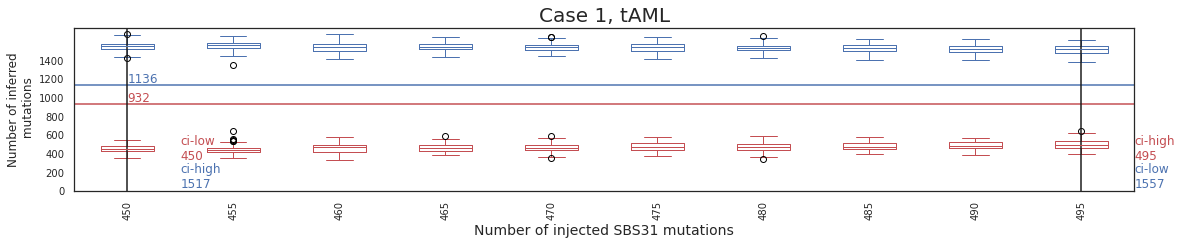

In [127]:
sample = 'AQ5187_vs_AQ5175'
text_loc_y1 = 600
text_loc_y2 = 300
interval = 200
x_min = 90
x_max = 100
y_max = 1510
ci_sbs31, ci_aging = plot_injections_aging(pt1_samples_dict,sample,text_loc_y1,text_loc_y2,interval,x_min,x_max,y_max)
ci_sbs31_dict[sample] = ci_sbs31
ci_aging_dict[sample] = ci_aging
plt.savefig('./figures_paper/sensitibity_'+sample+'.png',dpi=300, format='png',transparent=True,bbox_inches='tight')


In [150]:
sample = 'AU2198'
text_loc_y1 = 460
text_loc_y2 = 180
ci_sbs31, ci_aging = plot_injections_aging(all_samples_dict,sample,text_loc_y1, text_loc_y2)
ci_sbs31_dict[sample] = ci_sbs31
ci_aging_dict[sample] = ci_aging
plt.savefig('./figures_paper/sensitibity_'+sample+'.png',dpi=300, format='png',transparent=True,bbox_inches='tight')


FileNotFoundError: [Errno 2] File ./synthetic_samples_sensitibity/AU2198/SBS31/results.count_matrix.tsv.mSigAct.SBS31.tsv does not exist: './synthetic_samples_sensitibity/AU2198/SBS31/results.count_matrix.tsv.mSigAct.SBS31.tsv'

Confidence interval sbs31:
(125, 260)
Confidence interval aging:
630 730


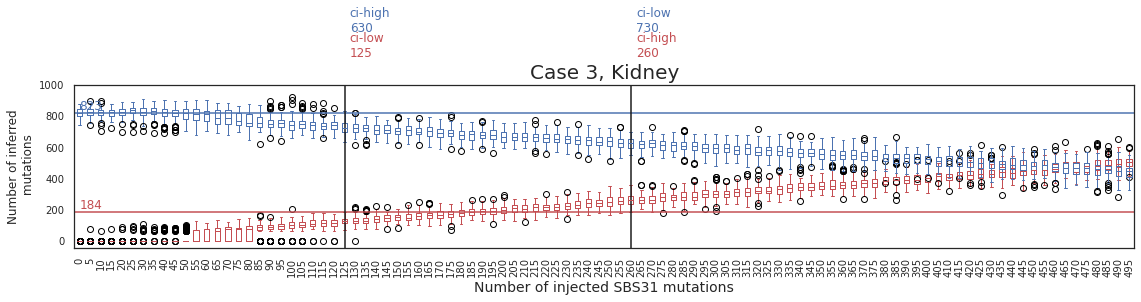

In [75]:
sample = 'AZ4609'
text_loc_y1 = 1340
text_loc_y2 = 1500
interval = 200
x_min = 0
x_max = 500
y_max = 1100
ci_sbs31, ci_aging = plot_injections_aging(all_samples_dict,sample,text_loc_y1, text_loc_y2,interval,x_min,x_max,y_max)
ci_sbs31_dict[sample] = ci_sbs31
ci_aging_dict[sample] = ci_aging
plt.savefig('./figures_paper/sensitibity_'+sample+'.png',dpi=300, format='png',transparent=True,bbox_inches='tight')


Confidence interval sbs31:
(175, 305)
Confidence interval aging:
530 638


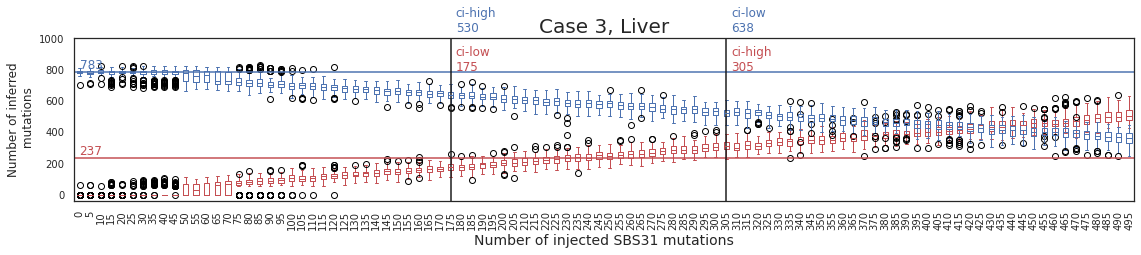

In [67]:
sample = 'AZ4610'
text_loc_y1 = 950
text_loc_y2 = 1200
interval = 200
x_min = 0
x_max = 500
y_max = 1100
ci_sbs31, ci_aging = plot_injections_aging(all_samples_dict,sample,text_loc_y1, text_loc_y2,interval,x_min,x_max,y_max)
ci_sbs31_dict[sample] = ci_sbs31
ci_aging_dict[sample] = ci_aging
plt.savefig('./figures_paper/sensitibity_'+sample+'.png',dpi=300, format='png',transparent=True,bbox_inches='tight')


Confidence interval sbs31:
(60, 140)
Confidence interval aging:
309 376


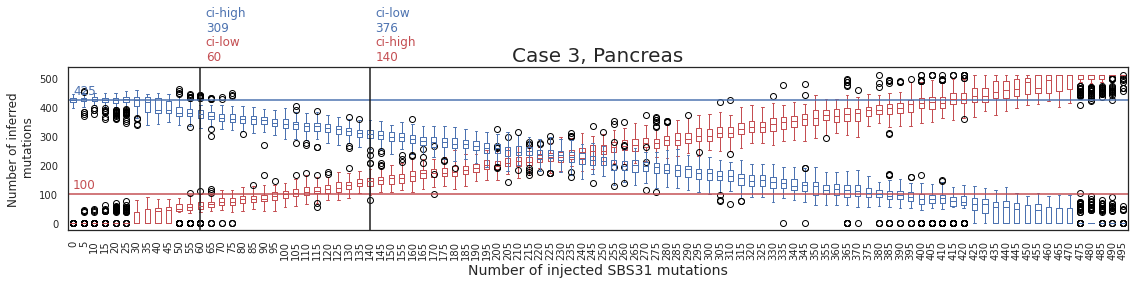

In [68]:
sample = 'AZ4611'
text_loc_y1 = 650
text_loc_y2 = 750
interval = 100
x_min = 0
x_max = 500
y_max = 550
ci_sbs31, ci_aging = plot_injections_aging(all_samples_dict,sample,text_loc_y1, text_loc_y2,interval,x_min,x_max,y_max)
ci_sbs31_dict[sample] = ci_sbs31
ci_aging_dict[sample] = ci_aging
plt.savefig('./figures_paper/sensitibity_'+sample+'.png',dpi=300, format='png',transparent=True,bbox_inches='tight')


Confidence interval sbs31:
(50, 170)
Confidence interval aging:
606 726


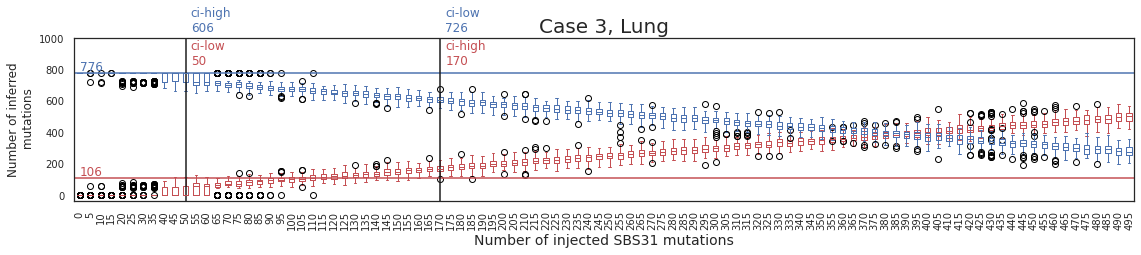

In [69]:
sample = 'AZ4612'
text_loc_y1 = 990
text_loc_y2 = 1200
interval = 200
x_min = 0
x_max = 500
y_max = 1100
ci_sbs31, ci_aging = plot_injections_aging(all_samples_dict,sample,text_loc_y1, text_loc_y2,interval,x_min,x_max,y_max)
ci_sbs31_dict[sample] = ci_sbs31
ci_aging_dict[sample] = ci_aging
plt.savefig('./figures_paper/sensitibity_'+sample+'.png',dpi=300, format='png',transparent=True,bbox_inches='tight')


Confidence interval sbs31:
(80, 160)
Confidence interval aging:
222 297


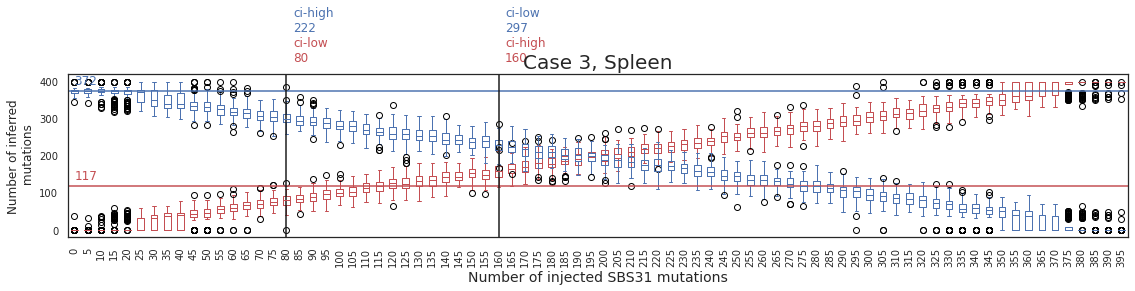

In [70]:
sample = 'AZ4613'
text_loc_y1 = 520
text_loc_y2 = 600
interval = 100
x_min = 0
x_max = 500
y_max = 410
ci_sbs31, ci_aging = plot_injections_aging(all_samples_dict,sample,text_loc_y1, text_loc_y2,interval,x_min,x_max,y_max)
ci_sbs31_dict[sample] = ci_sbs31
ci_aging_dict[sample] = ci_aging
plt.savefig('./figures_paper/sensitibity_'+sample+'.png',dpi=300, format='png',transparent=True,bbox_inches='tight')


Confidence interval sbs31:
(10, 70)
Confidence interval aging:
188 231


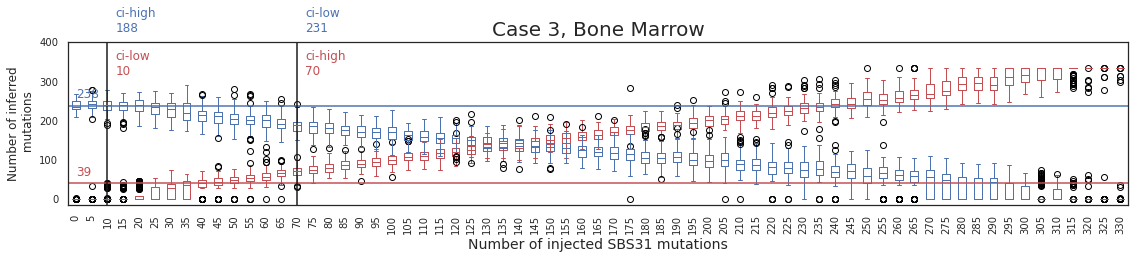

In [71]:
sample = 'AZ4614'
text_loc_y1 = 380
text_loc_y2 = 490
interval = 100
x_min = 0
x_max = 500
y_max = 410
ci_sbs31, ci_aging = plot_injections_aging(all_samples_dict,sample,text_loc_y1, text_loc_y2,interval,x_min,x_max,y_max)
ci_sbs31_dict[sample] = ci_sbs31
ci_aging_dict[sample] = ci_aging
plt.savefig('./figures_paper/sensitibity_'+sample+'.png',dpi=300, format='png',transparent=True,bbox_inches='tight')


In [72]:
print(ci_sbs31_dict)
print(ci_aging_dict)

{'AZ4609': (125, 260), 'AZ4610': (175, 305), 'AZ4611': (60, 140), 'AZ4612': (50, 170), 'AZ4613': (80, 160), 'AZ4614': (10, 70)}
{'AZ4609': (630, 730), 'AZ4610': (530, 638), 'AZ4611': (309, 376), 'AZ4612': (606, 726), 'AZ4613': (222, 297), 'AZ4614': (188, 231)}


In [88]:
print(ci_sbs31_dict)
print(ci_aging_dict)

{'AQ5181_vs_AQ5175': (0, 0), 'AQ5187_vs_AQ5175': (805, 1065), 'AU2198': (245, 290), 'AU2199': (15, 60), 'AU2200': (10, 60), 'AU2202': (5, 45), 'AZ4609': (110, 260), 'AZ4610': (175, 305), 'AZ4611': (60, 140), 'AZ4612': (60, 170), 'AZ4613': (75, 155), 'AZ4614': (20, 60), 'AZ6342': (0, 30), 'AZ6371': (5, 25)}
{'AQ5181_vs_AQ5175': (991, 991), 'AQ5187_vs_AQ5175': (1020, 1247), 'AU2198': (22, 28), 'AU2199': (0, 0), 'AU2200': (208, 235), 'AU2202': (96, 125), 'AZ4609': (630, 741), 'AZ4610': (530, 638), 'AZ4611': (309, 376), 'AZ4612': (606, 716), 'AZ4613': (227, 302), 'AZ4614': (195, 224), 'AZ6342': (86, 105), 'AZ6371': (37, 57)}


In [477]:
import json

In [486]:
file = './confidence_intervals/ci_sbs31.json'
json.dump(ci_sbs31_dict,open(file,'w'))
file = './confidence_intervals/ci_aging.json'
json.dump(ci_aging_dict,open(file,'w'))